In [2]:
import pandas as pd
import plotly.express as px
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

# set plotly parameters
import plotly.io as pio
pio.renderers.default='notebook'

In [10]:
# Read stock prices data
NYSE = pd.read_csv('CSV Files with Calculated Indicators/NYSE.csv')

# Select only the Date and Adj Close price
stocks_df = NYSE[["Date", "Adj Close"]].copy()

# rename the columns
stocks_df.rename(columns={"Adj Close": "NYSE"}, inplace = True)

# sort by date & visualize the df
stocks_df = stocks_df.sort_values(by = ['Date'])
stocks_df

,Date,NYSE
0,37187,5906.799805
1,37188,5890.410156
2,37189,5952.589844
3,37190,5990.859863
4,37193,5877.410156
...,...,...
5566,45282,16770.449220
5567,45286,16859.490230
5568,45287,16898.339840
5569,45288,16890.580080


In [11]:
# normalize the prices and plot chart for AAPL
normalized_stocks_df = stocks_df.copy()
normalized_stocks_df.iloc[:, 1:] = normalized_stocks_df.iloc[:, 1:].div(normalized_stocks_df.iloc[0, 1:], axis=1)

In [12]:
# desired ticker to analyse/predict
target_ticker = 'NYSE'

# build a dataframe with 3 columns: date, close price, target price (for the prediction)
df = pd.DataFrame({'Date': stocks_df['Date'], 'Close': stocks_df[target_ticker]})

# Build the target prices i.e. the next day's close price
df['Target'] = df['Close'].shift(-1) # Target stock price today will be tomorrow's price

# Remove the last row as it will be a NaN for the target column
price_target_df = df[:-1]
price_target_df

,Date,Close,Target
0,37187,5906.799805,5890.410156
1,37188,5890.410156,5952.589844
2,37189,5952.589844,5990.859863
3,37190,5990.859863,5877.410156
4,37193,5877.410156,5781.080078
...,...,...,...
5565,45281,16724.919920,16770.449220
5566,45282,16770.449220,16859.490230
5567,45286,16859.490230,16898.339840
5568,45287,16898.339840,16890.580080


In [13]:
# Get the close data as input data
input_data = price_target_df.Close.values # get the close price (true prices)
input_data = input_data.reshape(-1,1) # reshape to column vector

# scale to [0,1] again
sc = MinMaxScaler()
input_scaled = sc.fit_transform(input_data)
input_scaled

array([[0.12801342],
       [0.12676492],
       [0.13150153],
       ...,
       [0.9623484 ],
       [0.96530781],
       [0.9647167 ]])

In [14]:
# Create the training and testing data, training data contains present day and previous day values
X = []
y = []
for i in range(1, len(input_scaled)):
    X.append(input_scaled[i-1:i, 0])
    y.append(input_scaled[i, 0])
    
# Convert the data into array format
X = np.asarray(X)
y = np.asarray(y)

In [15]:
# Reshape the 1D arrays to 3D arrays to feed in the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42, shuffle=False)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_train.shape, X_test.shape

((3619, 1, 1), (1950, 1, 1))

In [16]:
# Create the model
inputs = keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
x = keras.layers.LSTM(150, return_sequences= True)(inputs)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.LSTM(150, return_sequences=True)(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.LSTM(150)(x)
outputs = keras.layers.Dense(1, activation='linear')(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss="mse")
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1, 1)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 1, 150)              │          91,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 150)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 1, 150)              │         180,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1, 150)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 150)                 │         180,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             151 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 452,551 (1.73 MB)

 Trainable params: 452,551 (1.73 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs = 50,
    batch_size = 32,
    validation_split = 0.2
)

# estimate the R2 on the test set
print("LSTM coefficient of determination of the prediction: ", r2_score(y_test, model.predict(X_test)))

Epoch 1/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0275 - val_loss: 0.0028
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.6819e-04 - val_loss: 5.2618e-05
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.6469e-04 - val_loss: 5.3581e-05
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.3580e-04 - val_loss: 4.6388e-05
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.0605e-04 - val_loss: 7.7962e-05
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.0897e-04 - val_loss: 8.0219e-05
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.6303e-04 - val_loss: 5.2424e-05
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.6321e-04 - val_loss: 4.5162e-05
Epoch 9/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.4762e-04 - val_loss: 4.4571e-05
Epoch 10/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.5312e-04 - val_loss: 9.0843e-05
Epoch 11/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.4924e-04 - val_loss: 4.75

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


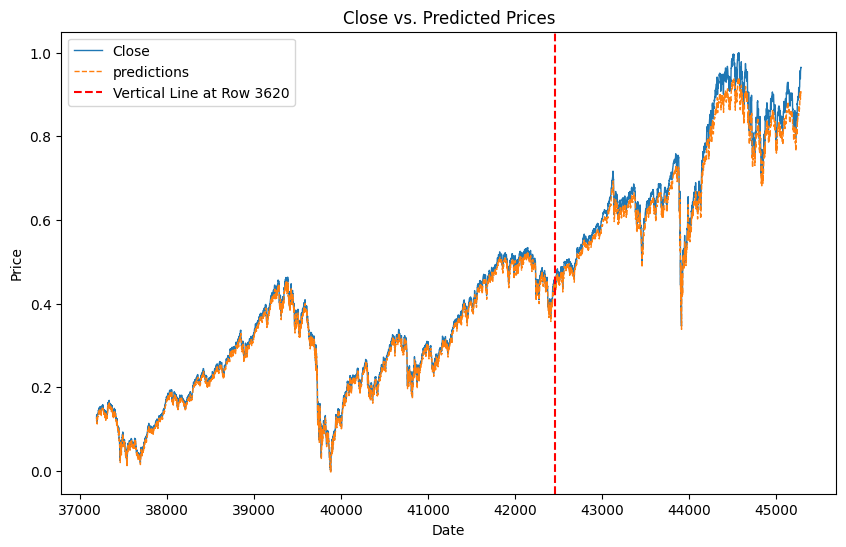

In [18]:
# Make prediction
#predicted = model.predict(X)
predicted = model.predict(np.reshape(X, (X.shape[0], X.shape[1], 1)))

# make list
predicted = predicted.ravel().tolist()

# make dataframe
df_predicted = price_target_df[1:][['Date']]
df_predicted['predictions'] = predicted
df_predicted['Close'] = input_scaled[1:]
df_predicted


# Assuming your DataFrame is named df
# Replace 'Date', 'Close', and 'Predicted' with your actual column names
plt.figure(figsize=(10, 6))
plt.plot(df_predicted['Date'], df_predicted['Close'], label='Close', linewidth=1)
plt.plot(df_predicted['Date'], df_predicted['predictions'], label='predictions', linestyle='dashed', linewidth=1)

# Add a vertical line at row 1798
plt.axvline(x=df['Date'].iloc[3620], color='red', linestyle='--', label='Vertical Line at Row 3620')

# Customize the plot
plt.title('Close vs. Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(False)
plt.xticks(rotation=0)

# Show the plot
plt.show()